In [1]:
import numpy as np
import pandas as pd

from dask.distributed import Client

# git clone https://github.com/aminnj/daskucsd
# and make workerenv tarball as specified in those instructions
from daskucsd.condor_utils import make_htcondor_cluster

In [2]:
cluster = make_htcondor_cluster(local=False, dashboard_address=13345,memory="4GB")
cluster

In [3]:
# or scale by hand
cluster.scale(75)

In [4]:
client = Client(cluster)
client

Client Scheduler: tcp://169.228.130.74:15931 Dashboard: http://169.228.130.74:13345/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
# Get condor job attributes from each worker

def f():
    import subprocess
    return subprocess.getoutput("grep ProcId $_CONDOR_JOB_AD")
# client.run(f,workers=["tcp://169.228.131.97:33361"])
client.run(f)

{'tcp://169.228.131.254:37572': 'ProcId = 0\nJOB_GLIDEIN_ProcId = "1"\nJobAdInformationAttrs = "JOB_Site JOB_GLIDEIN_Entry_Name JOB_GLIDEIN_Name JOB_GLIDEIN_Factory JOB_GLIDEIN_Schedd JOB_GLIDEIN_ClusterId JOB_GLIDEIN_ProcId JOB_GLIDEIN_Site JOB_GLIDEIN_SiteWMS JOB_GLIDEIN_SiteWMS_Slot JOB_GLIDEIN_SiteWMS_JobId JOB_GLIDEIN_SiteWMS_Queue"',
 'tcp://169.228.132.100:5496': 'ProcId = 0\nJOB_GLIDEIN_ProcId = "0"\nJobAdInformationAttrs = "JOB_Site JOB_GLIDEIN_Entry_Name JOB_GLIDEIN_Name JOB_GLIDEIN_Factory JOB_GLIDEIN_Schedd JOB_GLIDEIN_ClusterId JOB_GLIDEIN_ProcId JOB_GLIDEIN_Site JOB_GLIDEIN_SiteWMS JOB_GLIDEIN_SiteWMS_Slot JOB_GLIDEIN_SiteWMS_JobId JOB_GLIDEIN_SiteWMS_Queue"',
 'tcp://169.228.132.111:30285': 'ProcId = 0\nJOB_GLIDEIN_ProcId = "0"\nJobAdInformationAttrs = "JOB_Site JOB_GLIDEIN_Entry_Name JOB_GLIDEIN_Name JOB_GLIDEIN_Factory JOB_GLIDEIN_Schedd JOB_GLIDEIN_ClusterId JOB_GLIDEIN_ProcId JOB_GLIDEIN_Site JOB_GLIDEIN_SiteWMS JOB_GLIDEIN_SiteWMS_Slot JOB_GLIDEIN_SiteWMS_JobId JOB_

In [13]:
# client.shutdown()
# client.retire_workers(workers=["tcp://169.228.131.97:33361"],)
# client.restart()

In [14]:
# port forward 13345 to your laptop and either open this url in a new tab, or keep in an IFrame here

# from IPython.display import IFrame    
# IFrame('http://localhost:13345/status', width="100%", height=750)

In [9]:
def f():
    import psutil
    ret = psutil.virtual_memory()
    return ret
out = client.run(f)
data = []
for k,v in out.items():
    data.append(dict(name=k,
                     total=v.total//1e9,
                     available=v.available//1e9,
                     used=v.used//1e9,
                     free=v.free//1e9,
                     active=v.active//1e9,
                     inactive=v.inactive//1e9,
                     buffers=v.buffers//1e9,
                     cached=v.cached//1e9,
                     shared=v.shared//1e9,
                     slab=v.slab//1e9,
                    ))
df = pd.DataFrame(data).set_index("name")

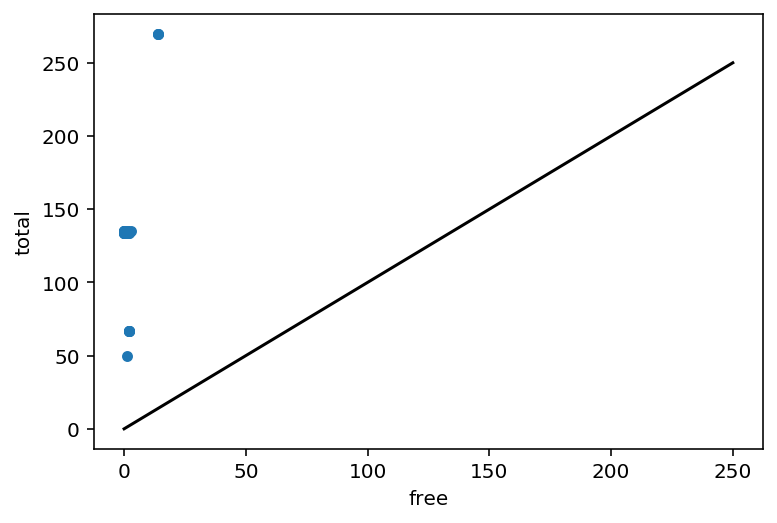

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# df.plot.scatter(ax=ax,x="available",y="total")
df.plot.scatter(ax=ax,x="free",y="total")
ax.plot([0,250],[0,250],color="k")

In [11]:
df.query("free < 1")

,total,available,used,free,active,inactive,buffers,cached,shared,slab
name,,,,,,,,,,
tcp://169.228.131.86:37097,135.0,98.0,36.0,0.0,44.0,82.0,3.0,93.0,0.0,6.0
tcp://169.228.131.86:40762,135.0,98.0,36.0,0.0,44.0,82.0,3.0,93.0,0.0,6.0
tcp://169.228.131.86:41178,135.0,98.0,36.0,0.0,44.0,82.0,3.0,93.0,0.0,6.0
tcp://169.228.131.86:42619,135.0,98.0,36.0,0.0,44.0,82.0,3.0,93.0,0.0,6.0
tcp://169.228.131.86:45870,135.0,98.0,36.0,0.0,44.0,82.0,3.0,93.0,0.0,6.0
tcp://169.228.132.112:41329,134.0,77.0,56.0,0.0,73.0,49.0,0.0,77.0,0.0,9.0
tcp://169.228.132.135:38346,134.0,113.0,21.0,0.0,41.0,82.0,0.0,112.0,0.0,8.0
tcp://169.228.132.135:38647,134.0,113.0,21.0,0.0,41.0,82.0,0.0,112.0,0.0,8.0
tcp://169.228.132.150:21331,134.0,79.0,55.0,0.0,55.0,62.0,0.0,78.0,0.0,10.0


In [12]:
import time
for i in range(100):
    tail = []
    for k,v in client.processing().items():
        if len(v):
            tail.append(k)
    x = df[df.index.isin(tail)]
    nbad = (x["free"] < 1).sum()
    ntot = len(tail)
    print(nbad,ntot)
    time.sleep(1)

1 11
1 11
1 11
1 11
1 11
1 11
1 11
1 11
1 12
1 12
1 12
1 11
1 13
1 12
1 9
1 8
0 7
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6
0 6


KeyboardInterrupt: 

In [10]:
import subprocess
def f():
    return subprocess.getoutput("hostname")
worker_to_hostname = client.run(f)#,priority=100)
worker_to_hostname = {k:v+":"+k.rsplit(":",1)[-1] for k,v in worker_to_hostname.items()}
{worker_to_hostname[k]:len(v) for k,v in client.processing().items()}

{'cabinet-7-7-5.t2.ucsd.edu:33719': 0,
 'cabinet-7-7-5.t2.ucsd.edu:34152': 0,
 'cabinet-7-7-5.t2.ucsd.edu:37164': 0,
 'cabinet-7-7-5.t2.ucsd.edu:39000': 0,
 'cabinet-7-7-5.t2.ucsd.edu:39299': 0,
 'sdsc-1.t2.ucsd.edu:13393': 0,
 'sdsc-12.t2.ucsd.edu:1187': 0,
 'sdsc-41.t2.ucsd.edu:44626': 0,
 'sdsc-77.t2.ucsd.edu:21061': 0,
 'sdsc-83.t2.ucsd.edu:15380': 0}

distributed.utils - ERROR - 'data'
Traceback (most recent call last):
  File "/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/distributed/scheduler.py", line 3030, in rebalance
    result = await asyncio.gather(
  File "/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/distributed/utils_comm.py", line 386, in retry_operation
    return await retry(
  File "/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/distributed/utils_comm.py", line 379, in retry
    return await coro()
  File "/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/distributed/core.py", line 757, in send_recv_from_rpc
    result = await send_recv(comm=comm, op=key, **kwargs)
  File "/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/distrib